In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    %matplotlib inline
    
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

In [2]:
import pandas as pd
import os
import time
import numpy as np
import io
import requests
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
# Read MFCCs feature CSV file of audio of 100ms block

path="/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/500ms/training"
#filename=os.path.join(path,"5class_100ms_file.csv")
#filename=os.path.join(path,"/home/iit/Desktop/project_mani/5classfet1.csv")
df=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/500ms/training/final_500ms.csv")
df.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12', 'Label']
filename_write = os.path.join(path,"/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/500ms/training/4class_new100ms_write.csv")
#df=pd.read_csv(filename)
df.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-0.361833,30.413287,14.026782,3.524097,-1.126189,1.995557,-2.024195,6.487043,-0.866477,7.117056,0.499036,4.950554,1.120927,AC & FAN
1,-0.314923,30.727571,14.676690,3.474063,-1.228633,2.278191,-1.999299,6.654512,-0.886767,7.060178,0.484853,4.293945,0.555153,AC & FAN
2,-0.322472,30.330372,14.470898,3.451456,-1.049604,2.263557,-2.018792,6.586320,0.119022,7.385747,0.928325,4.774701,0.638041,AC & FAN
3,-0.242023,30.538032,15.071904,3.793800,-0.413262,2.643561,-2.797349,5.827424,-0.243589,7.820150,2.213806,6.117095,0.799352,AC & FAN
4,-0.247731,30.773976,15.205313,3.309456,-1.786837,2.169586,-2.345875,5.909542,-0.580713,7.892582,1.763518,6.078295,1.073195,AC & FAN


In [4]:
# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)


In [5]:
# Encode to a 2D matrix for training
Label=encode_text_index(df,'Label')
print("Labelling is:{}".format(Label))

############################################################################################

# Sperating Independent variable and Target Variable
x,y=to_xy(df,'Label')

Labelling is:['AC & FAN' 'CRYING' 'MUSIC' 'SPEECH']


/home/bsplab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [6]:
# Keep a 20% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.20) 

In [7]:
print("Shape of x : {}".format(x.shape))
print("Shape of y : {}".format(y.shape))
print("Shape of x_main : {}".format(x_main.shape))
print("Shape of x_holdout : {}".format(x_holdout.shape))
print("Shape of y_main : {}".format(y_main.shape))
print("Shape of y_holdout : {}".format(y_holdout.shape))

Shape of x : (575855, 13)
Shape of y : (575855, 4)
Shape of x_main : (460684, 13)
Shape of x_holdout : (115171, 13)
Shape of y_main : (460684, 4)
Shape of y_holdout : (115171, 4)


In [8]:
# Cross-validate
kf = KFold(5)
epochs=30
oos_y = []
oos_pred = []
fold = 0
plot_loss = np.empty ((0,epochs))
plot_acc = np.empty ((0,epochs))
for train, test in kf.split(x_main):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
#####################################################################################    
# Training 
# Fully Connected Neural Network Model    
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(50, activation='relu')) # Hidden 2
    model.add(Dense(25, activation='relu')) # Hidden 3
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto') 
    checkpointer = ModelCheckpoint(filepath="best_weights_myFNN_new4C_500ms.hdf5",
                               verbose=2,
                               save_best_only=True) # save best model

    start_time = time.time()
    history=model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],
                      verbose=0,batch_size=128,epochs=epochs)
    
    #################################################################################
    ## Testing 
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)
    
#############################################################################################
    
    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {}".format(score))
    
#######################
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time))) 
    
####################################################################################################

    ###############################################
    loss = history.history['loss']
    #plt.plot(epochs,loss,label=='Training loss')
    acc = history.history['acc']
    plot_loss = np.append (plot_loss, [loss],axis=0)
    plot_acc = np.append (plot_acc, [acc],axis=0)
    ###############################################
    cm = confusion_matrix(y_compare,pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    ##############################################



# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print("Final score (accuracy): {}".format(score))  

#######################################################################################################    

# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)

#####################################################################

model.summary()

Fold #1
Fold score (accuracy): 0.9861293508579615
Elapsed time: 0:02:57.66
Confusion matrix, without normalization
[[23161     0     0     0]
 [    1 22579   116   195]
 [    3   125 22734   393]
 [    6   152   287 22385]]
Fold #2
Fold score (accuracy): 0.9852719320142831
Elapsed time: 0:03:01.04
Confusion matrix, without normalization
[[22964     1     4     5]
 [    0 22792   121   153]
 [    0   153 22256   479]
 [    3   206   232 22768]]
Fold #3
Fold score (accuracy): 0.9855866807037347
Elapsed time: 0:03:08.22
Confusion matrix, without normalization
[[23130     0     0     1]
 [    0 22584   156   322]
 [    1   100 22521   306]
 [    2    83   357 22574]]
Fold #4
Fold score (accuracy): 0.9852176649988604
Elapsed time: 0:03:12.84
Confusion matrix, without normalization
[[23030     0     2     0]
 [    1 22694    83   201]
 [    8   219 22227   443]
 [    4   141   260 22824]]
Fold #5
Fold score (accuracy): 0.984294955283494
Elapsed time: 0:03:16.57
Confusion matrix, without norm

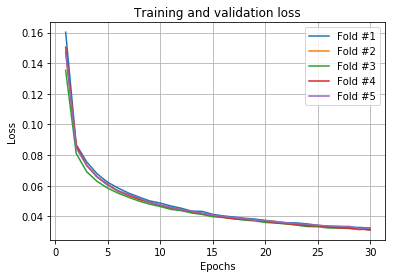

In [9]:
plot_loss_graph = plot_loss
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_loss_graph[i-1],label="Fold #{}".format(i))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("mani_4C_loss_500ms.eps")
plt.savefig("mani_4class_loss_500ms.png",dpi=150)
plt.show()

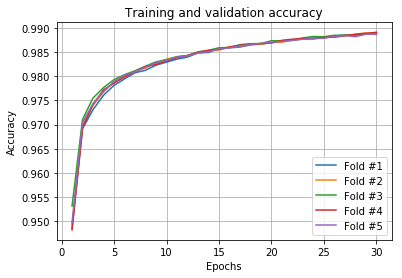

In [10]:
plt.clf()
plot_acc_graph = plot_acc
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_acc_graph[i-1],label="Fold #{}".format(i))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("mani_k-fold_4C_acc_500ms.eps",dpi=150)
plt.savefig('mani_k-fold_4C_acc_500ms.png',dpi=150)
plt.show()

In [11]:
from keras.utils.vis_utils import plot_model
#import pydot
#import pydot as pydot
import matplotlib.pyplot as plt
#from keras.utils.vis_utils import plot_model
plot_model(model, to_file='my_mani_500ms.png', show_shapes=True, show_layer_names=True)

Populating the interactive namespace from numpy and matplotlib


/home/bsplab/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


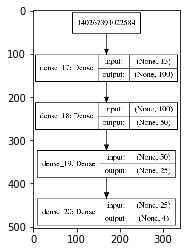

In [12]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('my_mani_500ms.png')
imgplot = plt.imshow(img)
plt.show()
from PIL import Image
image = Image.open('my_mani_500ms.png')
image.show()


In [13]:
## Turn off the scintific notation 
np.set_printoptions(suppress=True)

In [14]:
# Write the cross-validated prediction 
import time
tic = time.time()
holdout_pred = model.predict(x_holdout)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

1930.7584762573242ms


In [15]:
score = metrics.log_loss(y_holdout, holdout_pred)
print("Log loss score of Holdout data: {}".format(score))

Log loss score of Holdout data: 0.04951144941897229


In [16]:
# Measure accuracy
holdout_pred = model.predict(x_holdout)
holdout_pred = np.argmax(holdout_pred, axis=1)
y_holdout_compare = np.argmax(y_holdout, axis=1)
score = metrics.accuracy_score(y_holdout_compare, holdout_pred)
print("Holdout accuracy: {}".format(score))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Holdout accuracy: 0.9839369285670873
Elapsed time: 0:03:33.40


Confusion matrix, without normalization
[[28766     0     1     4]
 [    0 28456   198   278]
 [    3   220 28123   640]
 [    5   189   312 27976]]


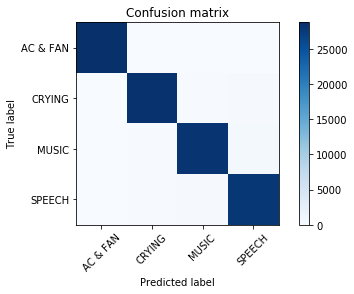

In [17]:


# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare, holdout_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, Label)
plt.savefig('cm_holdout_4C_myFNN_500ms.png',dpi=150)

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.98 0.01 0.01]
 [0.   0.01 0.97 0.02]
 [0.   0.01 0.01 0.98]]


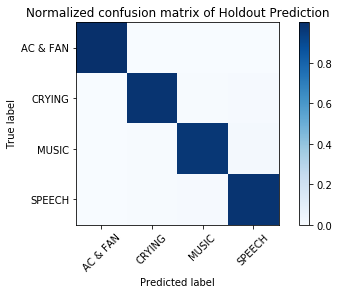

In [18]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, Label, title='Normalized confusion matrix of Holdout Prediction')
plt.savefig('norm_cm_holdout_4C_myFNN.png',dpi=150)
plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_holdout_compare, holdout_pred))  
print(classification_report(y_holdout_compare, holdout_pred))

[[28766     0     1     4]
 [    0 28456   198   278]
 [    3   220 28123   640]
 [    5   189   312 27976]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28771
           1       0.99      0.98      0.98     28932
           2       0.98      0.97      0.98     28986
           3       0.97      0.98      0.98     28482

   micro avg       0.98      0.98      0.98    115171
   macro avg       0.98      0.98      0.98    115171
weighted avg       0.98      0.98      0.98    115171



Confusion matrix, without normalization


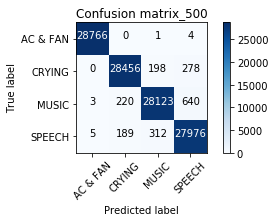

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_holdout_compare, holdout_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(5,3))
plot_confusion_matrix(cnf_matrix, classes=['AC & FAN', 'CRYING','MUSIC', 'SPEECH'],
                      title='Confusion matrix_500')

plt.savefig('kfold_fnn_mani_500ms.png')

In [21]:
[[C1,E1,N1,S1],[C2,E2,N2,S2],[C3,E3,N3,S3],[C4,E4,N4,S4]]=cm

TP=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
TN=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
FP=np.sum(cm)-TP
FN=FP


Acc=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])/np.sum(cm)
print("Overall Accuracy: ",Acc*100)

Pr=(TP)/(TP+FP)
print("Precision: ",Pr*100)

Se=(TP)/(TP+FN)
print("Sensitivity/Recall: ",Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=1-Acc
print("Error Rate: ",100*ER)

F_score = 2*TP /(2*TP + FP + FN)
print("F1-Score: ",F_score*100)

Overall Accuracy:  98.39369285670873
Precision:  98.39369285670873
Sensitivity/Recall:  98.39369285670873
Specificity:  98.39369285670873
Error Rate:  1.6063071432912746
F1-Score:  98.39369285670873


In [22]:
tic = time.time()
model.save('manikanta_FeedforwardNN_4class_500ms.h5')
toc = time.time()
print(str(1000*(toc-tic))+"ms")

255.42640686035156ms


In [25]:
from keras.models import load_model
import time
tic = time.time()
loaded_mymodel= load_model('manikanta_FeedforwardNN_4class_500ms.h5')
toc = time.time()
print(str(1000*(toc-tic))+"ms")

1522.765874862671ms


In [31]:
df1=pd.read_csv('/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/500ms/testing/crytest_500ms.csv')
df1.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df1.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,0.608042,-30.940753,-27.159607,5.345244,25.946790,-6.822781,-13.691598,7.267448,-6.761558,18.124799,-21.399074,-5.863374,26.848989
1,2.566048,-38.049089,-42.226694,-17.603180,-2.100800,-19.395015,-13.348083,13.026216,7.050743,20.365930,-24.065191,0.415657,20.892712
2,2.578959,-40.044976,-45.729119,-22.430032,-7.769700,-25.052723,-19.106227,7.284098,1.478592,14.785409,-29.064009,-4.092647,16.663434
3,2.979923,-34.028767,-41.768890,-26.959979,-15.497842,-11.995418,-1.491131,24.434800,1.733556,9.399367,-29.313156,-4.852593,25.135717
4,3.486683,-31.588030,-38.511233,-25.265812,-14.348102,0.705937,3.463126,26.816061,-10.173797,15.004500,-19.319196,1.847799,26.732329


In [32]:

tic = time.time()
my_his=loaded_mymodel.predict(df1)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape


1736.4706993103027ms


(71981, 4)

In [33]:
test_pred = np.argmax(my_his, axis=1)
test_pred[150:380]
print(test_pred.shape)

(71981,)


In [34]:
test_pred.dtype

dtype('int64')

In [57]:
c =0
for i in  test_pred:
    if i== 1:
         c += 1
    else:
        continue 
if c > test_pred.size/2:
    print("The tested audio is Crying")
else:
    print("Error")
       
        
print("Count is " + str(c))


    

The tested audio is Crying
Count is 50834


In [36]:
TP=sum(test_pred==1)
TP

50834

In [37]:
x=c/test_pred.size
print('Accuracy is for testing with new environment data of Crying:',100*x)

Accuracy is for testing with new environment data of Crying: 70.62141398424583


In [38]:
df2=pd.read_csv('/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/500ms/testing/fanactest_500ms.csv')
df2.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df2.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-1.147305,24.926870,25.196984,14.598969,4.701556,8.285125,-0.387873,9.159251,-1.549527,7.663207,-0.889826,4.114196,-1.260702
1,-1.264855,23.237898,30.027120,16.835693,0.792283,7.430119,-0.566533,9.629534,-2.370927,6.388160,-0.454941,2.907120,0.160224
2,-1.255745,23.550951,29.823715,16.480579,1.063072,8.235484,-0.655905,9.443653,-2.376108,6.149231,-0.587636,2.157115,-0.059677
3,-1.228085,23.886075,30.329935,16.424163,0.971652,8.169525,-0.706878,9.646453,-2.547504,5.528921,-0.723708,2.201908,-0.420058
4,-1.397908,22.029001,29.486513,17.742132,3.249137,9.685773,0.063827,9.184852,-1.831122,6.013339,-0.467628,1.773869,-1.748630


In [39]:
tic = time.time()
my_his1=loaded_mymodel.predict(df2)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape


1493.7686920166016ms


(71981, 4)

In [40]:
test_pred1 = np.argmax(my_his1, axis=1)
test_pred1[150:380]
print(test_pred1.shape)

(71981,)


In [61]:
c =0
for i in  test_pred1:
    if i== 0:
         c += 1
    else:
        continue 
if c > test_pred1.size/2:
    print("The tested audio is acfan")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is acfan
Count is 37750


In [42]:
sum(test_pred1==0)

37750

In [43]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of acfan:',100*x)

Accuracy is for testing with new environment data of acfan: 52.4443950486934


In [44]:
df3=pd.read_csv('/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/500ms/testing/musictest_500ms.csv')
df3.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df3.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,0.136233,-21.402960,-25.454186,2.895125,-39.349499,16.982320,-12.056873,4.795090,3.897037,-11.572799,-4.980875,5.784769,28.804548
1,0.238459,-21.757170,-26.597538,1.907582,-38.983246,16.698487,-11.133345,6.984631,5.745933,-12.307385,-10.134391,6.409964,29.380517
2,0.406369,-22.204507,-26.661082,1.527427,-38.352845,17.471265,-12.856707,7.922898,6.859795,-12.191982,-11.659023,6.821548,30.606710
3,0.550474,-20.960420,-25.793995,1.560045,-37.519118,21.369094,-9.940701,9.826418,5.211300,-14.883692,-12.423846,7.916328,31.444307
4,0.646697,-21.985081,-27.201796,-1.861396,-37.519102,22.671990,-5.777302,9.324819,4.191169,-17.409886,-10.568379,11.364492,33.958904


In [45]:
tic = time.time()
my_his2=loaded_mymodel.predict(df3)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape

1489.884853363037ms


(71981, 4)

In [46]:
test_pred2 = np.argmax(my_his2, axis=1)
test_pred2[150:380]
print(test_pred2.shape)

(71981,)


In [65]:
c =0
for i in  test_pred2:
    if i== 2:
         c += 1
    else:
        continue 
if c > test_pred2.size/2:
    print("The tested audio is Music")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is Music
Count is 58236


In [48]:
x=c/test_pred2.size
print('Accuracy is for testing with new environment data of Music:',100*x)

Accuracy is for testing with new environment data of Music: 80.90468318028368


In [49]:
df4=pd.read_csv('/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/FNN+MFCC_nesshifting/500ms/testing/speechtest_500ms.csv')
df4.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df4.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-0.645231,6.840059,-34.698966,-5.163873,-16.421513,-26.127300,-24.478998,-13.912648,-11.309976,-35.330644,-6.705617,-16.910202,-15.692434
1,-1.667391,11.200022,-23.022258,-5.891074,-34.590220,-14.549208,-21.365258,-27.976360,-15.429641,-16.015957,-8.283700,-26.623802,-17.272402
2,-1.585208,10.116967,-22.687469,-2.415676,-38.096010,-16.526405,-16.803405,-30.404819,-21.994861,-7.813076,-4.934756,-26.487692,-12.165320
3,-1.516908,7.832669,-25.530028,-6.600405,-44.508747,-23.148706,-24.789159,-36.507218,-28.861830,-11.091044,-6.928644,-26.393281,-10.738367
4,-1.507291,3.994814,-15.046565,-11.634594,-36.561951,-21.951056,-20.664525,-30.408666,-34.948488,-0.227105,-12.399686,-22.507579,-16.058356


In [50]:
tic = time.time()
my_his3=loaded_mymodel.predict(df4)
toc = time.time()
print(str(1000*(toc-tic))+"ms")

my_his.shape

1471.9579219818115ms


(71981, 4)

In [51]:
test_pred3 = np.argmax(my_his3, axis=1)
test_pred3[150:380]
print(test_pred3.shape)

(71981,)


In [69]:
c =0
for i in  test_pred3:
    if i== 3:
         c += 1
    else:
        continue 
if c > test_pred3.size/2:
    print("The tested audio is speech")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is speech
Count is 66040


In [53]:
x=c/test_pred3.size
print('Accuracy is for testing with new environment data of speech:',100*x)

Accuracy is for testing with new environment data of speech: 91.74643308650894


In [ ]:
sum(test_pred3==3)